In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt



#makes viewing pandas tables better
pd.set_option('display.max_colwidth', 0)

# Download TNseq data

In [2]:
#change this to where your FASTQs are

FASTQ_directory = '/usr2/people/kayleeec/rhseq/20032023_novaseq'

How big is each FASTQ file?

In [3]:
fastq_files = !ls {FASTQ_directory}/*.fastq.gz

for f in fastq_files:

    size = !du -sh {f}
    size = size[0].split('\t')[0]
    
    print('{}: {}'.format(f, size))

/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB504-reseq_S1_L001_R1_001.fastq.gz: 898M
/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB504-reseq_S1_L001_R2_001.fastq.gz: 1.9G
/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB505-reseq_S2_L001_R1_001.fastq.gz: 898M
/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB505-reseq_S2_L001_R2_001.fastq.gz: 898M
/usr2/people/kayleeec/rhseq/1242023_tnseq/Undetermined_S0_L001_R1_001.fastq.gz: 385M
/usr2/people/kayleeec/rhseq/1242023_tnseq/Undetermined_S0_L001_R2_001.fastq.gz: 385M


## Merge paired end reads

This step combines the forward and reverse mate pairs from two fastq files.

Get list of TNseq fastq.gz sequencing files. We only need one file (R1) from each pair (R1, R2) because they have the same prefix (the file name before _R1_001 and _R2_001).

In [4]:
#check that these are the files you want - if not, set the fastq list to the correct list of paths by hand
#eg: fastqs = ['correctfile1_R1_001.fastq.gz', correctfile2_R1_001.fastq.gz]

fastqs = !ls {FASTQ_directory}/*.fastq.gz
fastqs

['/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB504-reseq_S1_L001_R1_001.fastq.gz',
 '/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB504-reseq_S1_L001_R2_001.fastq.gz',
 '/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB505-reseq_S2_L001_R1_001.fastq.gz',
 '/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB505-reseq_S2_L001_R2_001.fastq.gz',
 '/usr2/people/kayleeec/rhseq/1242023_tnseq/Undetermined_S0_L001_R1_001.fastq.gz',
 '/usr2/people/kayleeec/rhseq/1242023_tnseq/Undetermined_S0_L001_R2_001.fastq.gz']

We're using Melanie's install of bbmerge and nice -n 17 to put our code at the lowest priority on the server (it takes a lot of power and time and we want to be "nice" to other users). The code below takes ~20 minutes per 4Gb fastq file, will take longer if the files are bigger! There is useful information about the number of paired reads in the output below.

In [6]:
!mkdir /usr2/people/kayleeec/rhseq/1242023_tnseq/TNSeq_merge_FASTQ

In [7]:
for fastq in fastqs:
    
    fastq_prefix = fastq.replace('_R1_001.fastq.gz', '')
    output_prefix = '/usr2/people/kayleeec/rhseq/1242023_tnseq/TNSeq_merge_FASTQ/{}'.format(fastq_prefix.split('/')[-1])
    
    cmd = "nice -n 17 /usr2/people/mabrams/bin/bbmap/bbmerge.sh in1={}_R1_001.fastq.gz in2={}_R2_001.fastq.gz out={}_merged.fastq ihist={}_hist.txt".format(fastq_prefix,
                                                                                                          fastq_prefix,
                                                                                                          output_prefix,
                                                                                                          output_prefix)
    !{cmd}

java -ea -Xmx1000m -Xms1000m -Djava.library.path=/usr2/people/mabrams/bin/bbmap/jni/ -cp /usr2/people/mabrams/bin/bbmap/current/ jgi.BBMerge in1=/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB504-reseq_S1_L001_R1_001.fastq.gz in2=/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB504-reseq_S1_L001_R2_001.fastq.gz out=/usr2/people/kayleeec/rhseq/1242023_tnseq/TNSeq_merge_FASTQ/ADRB504-reseq_S1_L001_merged.fastq ihist=/usr2/people/kayleeec/rhseq/1242023_tnseq/TNSeq_merge_FASTQ/ADRB504-reseq_S1_L001_hist.txt
Executing jgi.BBMerge [in1=/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB504-reseq_S1_L001_R1_001.fastq.gz, in2=/usr2/people/kayleeec/rhseq/1242023_tnseq/ADRB504-reseq_S1_L001_R2_001.fastq.gz, out=/usr2/people/kayleeec/rhseq/1242023_tnseq/TNSeq_merge_FASTQ/ADRB504-reseq_S1_L001_merged.fastq, ihist=/usr2/people/kayleeec/rhseq/1242023_tnseq/TNSeq_merge_FASTQ/ADRB504-reseq_S1_L001_hist.txt]
Version 38.61

Writing mergable reads merged.
Started output threads.
Total time: 52.868 seconds.

Pairs

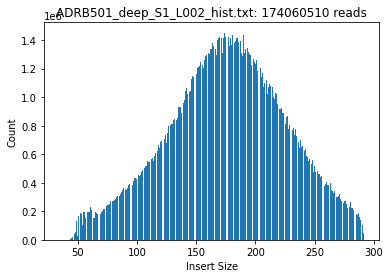

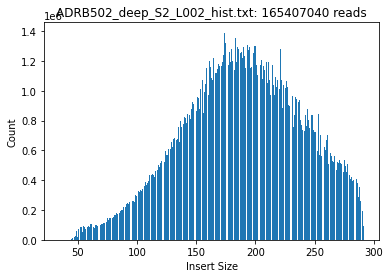

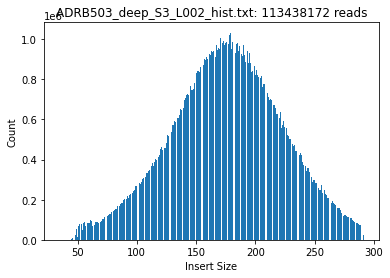

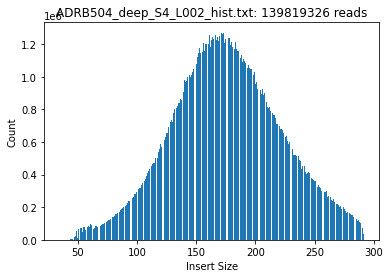

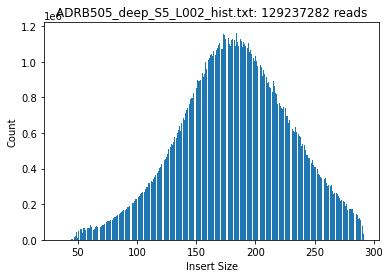

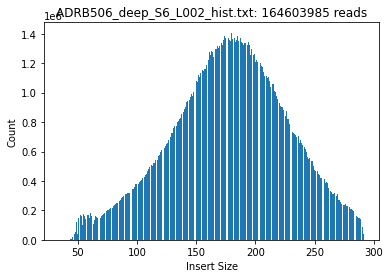

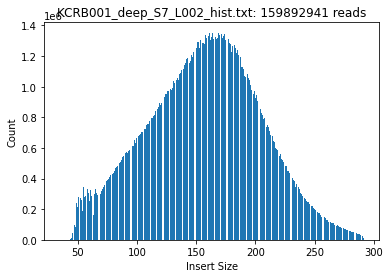

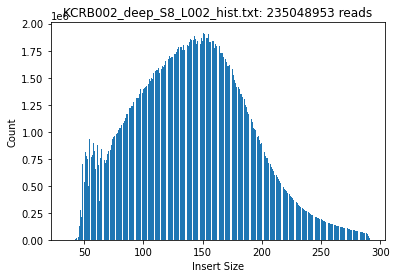

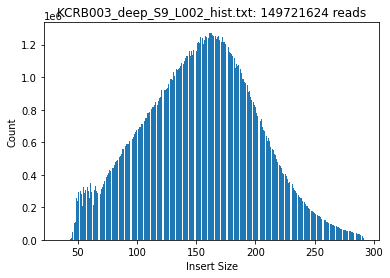

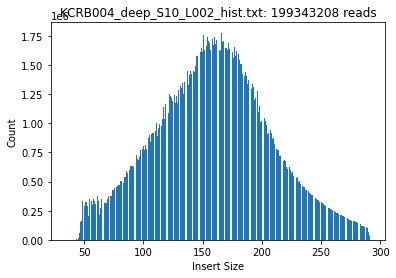

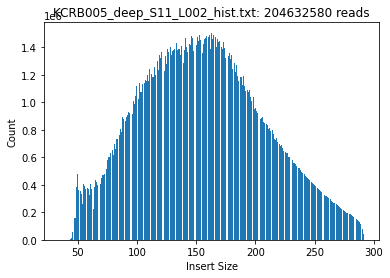

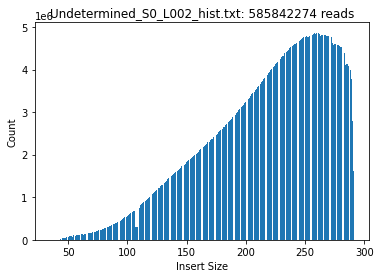

In [9]:
#plot output histograms of insert size vs. count

histogram_files = !ls /usr2/people/kayleeec/rhseq/20032023_novaseq/TNSeq_merge_FASTQ/*_hist.txt

for f in histogram_files:
    
    df = pd.read_csv(f, sep='\t', comment='#', header=None)
    df.columns = ['Insert Size', 'Count']
    
    reads = sum(df['Count'])
    
    plt.bar(df['Insert Size'], df['Count'])
    plt.ylabel('Count')
    plt.xlabel('Insert Size')
    plt.title('{}: {} reads'.format(f.split('/')[-1], reads))
    plt.show()

### Optional: randomly select reads from each FASTQ to create smaller files for testing code

It will take a long time to run the TNseq mapping on the full FASTQ files. For debugging/testing code, it's nice to have small files that are quick to process.

In [ ]:
FASTQ_directory = '../20032023_novaseq/TNSeq_merge_FASTQ'
num_seqs_to_sample = 10000
merged_FASTQs = !ls {FASTQ_directory}/*_merged.fastq

for f in merged_FASTQs:
    
    print(f)
    outfile = f.replace('.fastq', '_subsample.fastq')
    cmd = '/usr2/people/gtl/bin/seqtk/seqtk sample {} {}'.format(f, num_seqs_to_sample)
    
    !{cmd} > {outfile}


../20032023_novaseq/TNSeq_merge_FASTQ/ADRB501_deep_S1_L002_merged.fastq
../20032023_novaseq/TNSeq_merge_FASTQ/ADRB502_deep_S2_L002_merged.fastq
